# Introdução

O problema do caixeiro viajante (TSP) é um problema clássico de otimização combinatória. O problema pode ser formulado como: dado um conjunto de cidades e a distância entre cada par de cidades, encontrar o caminho mais curto que visita cada cidade exatamente uma vez e retorna à cidade de origem.

A formulação matemática utilizada neste trabalho, muito comum em contextos de pesquisa operacional, considera o custo Cij de percorrer uma cidade i a uma cidade j, assim como o caminho do grafo ser ou não percorrido (Xij).

Representando matemáticamente, temos:

$$\min \sum_{i=1}^{n} \sum_{j>i} c_{ij}x_{ij}$$


S.a.:
- $$\sum_{j<i} x_{ji} + \sum_{j>i} x_{ij} = 2, \quad \forall i \in \{1, 2, \dots, n\}$$
- $$\sum_{i,j \in S} x_{ij} \leq |S| - 1 \quad \forall S \subseteq N$$
- $$x \in \{0,1\}^{n(n-1)/2}$$

Neste trabalho, será utilizado um algoritmo genético por representação de permutação para resolver o problema do caixeiro viajante.

In [1]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from pandas import Series

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Criação da População e Parâmetros

Para iniciar a **população**, utilizando uma representação em permutação, inicialmente é necessário criar uma lista de cidades, onde cada cidade é representada por um número inteiro. Esta lista de cidades é baseada no arquivo "att48.tsp", que contém as coordenadas das cidades.

Será criado um dicinário chamado "coordinates" que terá como chave o índice do indivíduo e como valor as coordenadas do indivíduo. O dicionário "coordinates" será utilizado para calcular a distância entre as cidades.

> A forma que o problema é representado já faz com que todas as restrições sejam atendidas, pois cada cidade é visitada uma única vez.

In [2]:
def init_population() -> tuple[list[int], dict[int, tuple[int, int]]]:
    solution = []
    coordinates = {}

    with open('att48.tsp', 'r') as file:
        for line in file:
            if not line[0].isdigit() and "EOF" not in line:
                continue
            elif "EOF" in line:
                break

            current_city, x, y = line.split()
            current_city = int(current_city)
            x = int(x)
            y = int(y)

            solution.append(current_city)
            coordinates[current_city] = (x, y)

    population = [solution.copy() for _ in range(75)]
    for i in range(len(population)):
        rd.shuffle(population[i])

    return population, coordinates

# Função de Aptidão

Definimos a **aptidão** como a distância total percorrida pelo caixeiro viajante. Para calcular a distância total, é necessário calcular a distância entre cada par de cidades e somar todas as distâncias. O objetivo é minimizar a distância total percorrida.

In [3]:
def fitness(solution: list[int], coordinates: dict[int, tuple[int, int]]) -> int:
    total_distance = 0

    for i in range(len(solution) - 1):
        current_city = solution[i]
        next_city = solution[i + 1]

        x1, y1 = coordinates[current_city]
        x2, y2 = coordinates[next_city]

        total_distance += ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

    return total_distance

# Mutação da Solução (Swap)

Realizamos a **mutação** utilizando a técnica de **Swap**. Para isso, escolhemos aleatoriamente duas posições do vetor de representação do indivíduo e trocamos seus valores.
> **Exemplo:** Caso tenhamos escolhido as posições 2 e 4 para o vetor [0,1,2,3,4,5,6,7], teremos a mutação [0,1,4,3,2,5,6,7].

In [4]:
def mutate_solution_swap(solution):
    to_swap_lines = rd.sample(range(0,len(solution)), 2)
    solution[to_swap_lines[0]], solution[to_swap_lines[1]] = solution[to_swap_lines[1]], solution[to_swap_lines[0]]

# Seleção dos Pais

Para a **seleção dos pais**, utilizamos um método de **Torneio** alternativo. Neste método, escolhemos aleatoriamente cinco indivíduos da população e selecionamos os dois que possuem a menor função de aptidão como pais.

# Recombinação (Cut-and-crossﬁll)

Realizamos a **recombinação** utilizando a técnica de **Cut-and-crossﬁll**. Esse método irá criar dois filhos, cada um deles irá possuir uma parte inicial do vetor de um pai e irá 'retirar' os outros valores, que ainda não possui, do outro pai.

> Obs: As explicações de cada parte da técnica utilizada podem ser encontradas nos comentários dentro da própria função presente abaixo

In [5]:
def recombine_cut_and_crossfil(population, coordinates):
    # Escolha de 5 possíveis pais aleatoriamente
    random_possible_parents = [population[i] for i in rd.sample(range(0,len(population)), 5)]

    # Melhores duas possíveis soluções para pais
    best_possible_parents_indexes = np.argpartition([fitness(sol, coordinates) for sol in random_possible_parents] ,2)[:2]
    parent_1 = random_possible_parents[best_possible_parents_indexes[0]]
    parent_2 = random_possible_parents[best_possible_parents_indexes[1]]
    
    # Ter ao menos 1 elemento de cada pai para cada filho e preencher os filhos (inicialmente)
    first_section_cut_index = rd.choice(range(0, len(parent_1)-1))
    
    child_1 = np.zeros(len(parent_1))
    child_2 = np.zeros(len(parent_2))
    
    child_1[:first_section_cut_index+1] = parent_1[:first_section_cut_index+1]
    child_2[:first_section_cut_index+1] = parent_2[:first_section_cut_index+1]
    
    # Preenchendo o resto dos vetores filhos com as soluções dos próximos pais
    current_child_index = first_section_cut_index
    
    for value in parent_2:
        if current_child_index >= len(child_1)-1:
            break
        if value in child_1:
            continue
            
        child_1[current_child_index+1] = value
            
        current_child_index += 1
        
        
    current_child_index = first_section_cut_index
        
    for value in parent_1:
        if current_child_index >= len(child_2)-1:
            break
        if value in child_2:
            continue
            
        child_2[current_child_index+1] = value
            
        current_child_index += 1
        
    child_1 = [int(x) for x in child_1]
    child_2 = [int(x) for x in child_2]
        
    return child_1, child_2

# Escolha de Mutações

Realizamos com **10%** de chance a **mutação** para cada um dos dois filhos.

In [6]:
def mutate_childs(child_1, child_2):
    # Mutações em 10% das vezes para cada filho
    mutation_rate = 0.2
    
    if rd.uniform(0, 1) < mutation_rate:
        mutate_solution_swap(child_1)
        
    if rd.uniform(0, 1) < mutation_rate:
        mutate_solution_swap(child_2)

# Seleção de Candidatos

A **população** que continuará será referente aos n-2 indivíduos, após a inserção dos 2 filhos, que melhor se adaptam ao problema, ou seja, os 2  indivíduos com os piores valores de aptidão serão retirados da população.

In [7]:
def select_new_population(pop, child_1, child_2, coordinates):
    # Retirando piores duas soluções da nova população
    
    pop.append(child_1)
    pop.append(child_2)
    
    elements_indexes_to_pop = np.argpartition([fitness(sol, coordinates) for sol in pop], -2)[-2:]
    
    for index in sorted(elements_indexes_to_pop, reverse=True):
        del pop[index]
    
    return pop

# Encontrar a Solução
Uma função que nos permite realizar o processo de um **Algoritmo Evolucionário** de forma simples, sendo necessário escolher apenas a quantidade de indivíduos na população e quantas rainhas devem existir no tabuleiro. O formato do código se baseia no pseudocódigo descrito na Introdução.

In [8]:
def find_best_solution():
    max_generations = 100000

    pop, coordinates = init_population()

    current_generation = 0
    fitness_pop_vectors = []

    while True:
        fitness_pop = [fitness(sol, coordinates) for sol in pop]
        fitness_pop_vectors.append(min(fitness_pop))

        if 0 in fitness_pop or current_generation >= max_generations:
            break

        child_1, child_2 = recombine_cut_and_crossfil(pop, coordinates)

        mutate_childs(child_1, child_2)

        pop = select_new_population(pop, child_1, child_2, coordinates)

        current_generation += 1

    best_solution = pop[np.argmin(fitness_pop)]
    
    best_solution_fitness = min(fitness_pop)
    
    return best_solution, best_solution_fitness, current_generation, fitness_pop_vectors, coordinates

# Resultados

O algoritmo foi executado com 75 indivíduos e 10000 gerações. O resultado obtido foi uma distância de 40860, em que abaixo é possível noticiar o caminho percorrido pelo caixeiro viajante, assim como a evolução do algortimo.

Apesar de não ser o melhor resultado, o algoritmo genético foi capaz de encontrar uma boa solução para o caixeiro viajante e chegou em valores suficientemente bons com um tempo de execução razoável, tornando-se uma boa alternativa para a resolução do problema em casos de tempo restrito em comparação com métodos exatos.

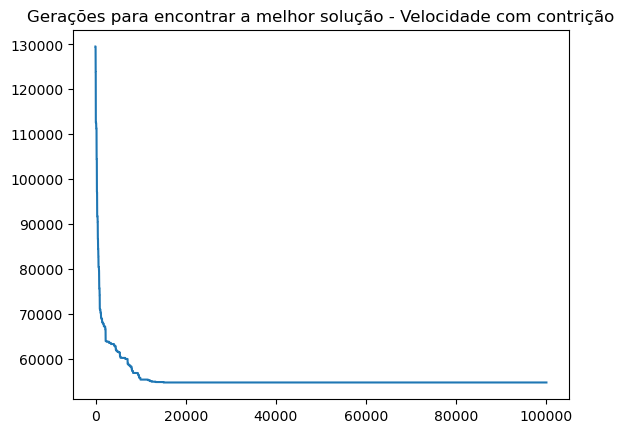

In [9]:
best_solution, best_solution_fitness, current_generation, fitness_pop_vectors, coordinates = find_best_solution()

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução - Velocidade com contrição")
plt.show()


Text(0.5, 1.0, 'Melhor solução encontrada com fitness: 54727.479688562635')

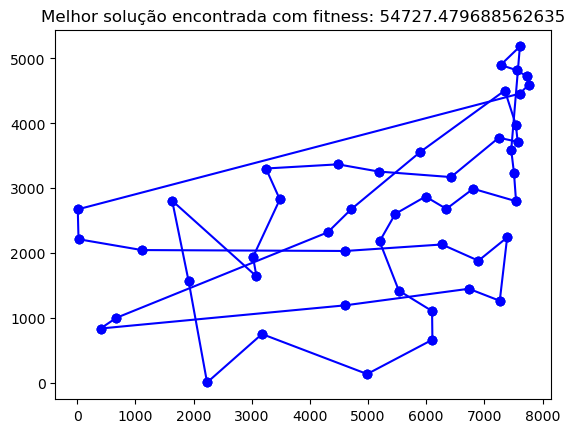

In [10]:
plt.figure()
x = [x for x, y in coordinates.values()]
y = [y for x, y in coordinates.values()]
plt.scatter(x, y)

for i in range(len(best_solution) - 1):
    plt.plot([coordinates[best_solution[i]][0], coordinates[best_solution[i + 1]][0]],
             [coordinates[best_solution[i]][1], coordinates[best_solution[i + 1]][1]], 'bo-')
plt.plot([coordinates[best_solution[-1]][0], coordinates[best_solution[0]][0]], [coordinates[best_solution[-1]][1], coordinates[best_solution[0]][1]], 'bo-')
plt.title(f"Melhor solução encontrada com fitness: {best_solution_fitness}")